In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler    

import torchvision
from torchvision import datasets,transforms 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

C:\Users\PC\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [5]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [6]:
train_dir = 'face_data24/train/'
test_dir = 'face_data24/val/'

In [7]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)

In [9]:
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [10]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8,
                                          shuffle=True, num_workers=4)

In [11]:
dataloaders = {
    'train': train_loader,
    'test': test_loader
}

In [14]:
class_names = train_data.classes

In [17]:
from torchvision import models

model = models.alexnet(pretrained=True)

In [47]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [19]:
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))

In [20]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
criterion   = nn.CrossEntropyLoss()

optimizer   = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
import time
import copy
import os

dataset_sizes = {
    'train': len(train_data),
    'test': len(test_data)
}

In [53]:
def train_model(model, criterion, optimizer, num_epochs=500):
    since = time.time()
    FT_losses = []
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                phase, epoch_loss, epoch_acc*100))
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

In [54]:
model, FT_losses = train_model(model, criterion, optimizer, num_epochs=300)

Epoch 1/300
----------
train Loss: 1.4864 Acc: 42.15%
test Loss: 1.0859 Acc: 53.33%
Epoch 2/300
----------
train Loss: 0.6271 Acc: 78.51%
test Loss: 0.9275 Acc: 70.00%
Epoch 3/300
----------
train Loss: 0.7521 Acc: 75.21%
test Loss: 1.3813 Acc: 43.33%
Epoch 4/300
----------
train Loss: 1.2695 Acc: 58.68%
test Loss: 0.9098 Acc: 63.33%
Epoch 5/300
----------
train Loss: 0.7996 Acc: 71.90%
test Loss: 0.6930 Acc: 73.33%
Epoch 6/300
----------
train Loss: 0.5371 Acc: 83.47%
test Loss: 0.7950 Acc: 63.33%
Epoch 7/300
----------
train Loss: 0.1707 Acc: 94.21%
test Loss: 0.6738 Acc: 70.00%
Epoch 8/300
----------
train Loss: 0.1913 Acc: 92.56%
test Loss: 1.0987 Acc: 70.00%
Epoch 9/300
----------
train Loss: 0.2699 Acc: 90.91%
test Loss: 0.9059 Acc: 66.67%
Epoch 10/300
----------
train Loss: 0.1003 Acc: 99.17%
test Loss: 0.2722 Acc: 90.00%
Epoch 11/300
----------
train Loss: 0.0467 Acc: 98.35%
test Loss: 1.1055 Acc: 73.33%
Epoch 12/300
----------
train Loss: 0.1028 Acc: 96.69%
test Loss: 0.5386 A

test Loss: 0.3558 Acc: 90.00%
Epoch 97/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3557 Acc: 90.00%
Epoch 98/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3549 Acc: 90.00%
Epoch 99/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3551 Acc: 90.00%
Epoch 100/300
----------
train Loss: 0.0001 Acc: 100.00%
test Loss: 0.3442 Acc: 93.33%
Epoch 101/300
----------
train Loss: 0.0001 Acc: 100.00%
test Loss: 0.3367 Acc: 93.33%
Epoch 102/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3364 Acc: 93.33%
Epoch 103/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3367 Acc: 93.33%
Epoch 104/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3369 Acc: 93.33%
Epoch 105/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3388 Acc: 93.33%
Epoch 106/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3391 Acc: 93.33%
Epoch 107/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3412 Acc: 93.33%
Epoch 108/300
--

train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3482 Acc: 93.33%
Epoch 192/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3484 Acc: 93.33%
Epoch 193/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3483 Acc: 93.33%
Epoch 194/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3485 Acc: 93.33%
Epoch 195/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3485 Acc: 93.33%
Epoch 196/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3487 Acc: 93.33%
Epoch 197/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3486 Acc: 93.33%
Epoch 198/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3487 Acc: 93.33%
Epoch 199/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3487 Acc: 93.33%
Epoch 200/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3486 Acc: 93.33%
Epoch 201/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3486 Acc: 93.33%
Epoch 202/300
----------
train Loss: 0.0001 Acc: 100.00%
test Loss: 

test Loss: 0.3524 Acc: 93.33%
Epoch 286/300
----------
train Loss: 0.0001 Acc: 100.00%
test Loss: 0.3590 Acc: 93.33%
Epoch 287/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3583 Acc: 93.33%
Epoch 288/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3583 Acc: 93.33%
Epoch 289/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3582 Acc: 93.33%
Epoch 290/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3584 Acc: 93.33%
Epoch 291/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3588 Acc: 93.33%
Epoch 292/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3587 Acc: 93.33%
Epoch 293/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3587 Acc: 93.33%
Epoch 294/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3583 Acc: 93.33%
Epoch 295/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3586 Acc: 93.33%
Epoch 296/300
----------
train Loss: 0.0000 Acc: 100.00%
test Loss: 0.3589 Acc: 93.33%
Epoch 297/300

In [55]:
with torch.no_grad():
    
    correct = 0
    total = 0

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])
    base_path = "face_data24/val/"

    test_data = datasets.ImageFolder(root=base_path,
                                transform=test_transform)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=8,
                                          shuffle=True, num_workers=4)

    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on the test images: {}%'.format(100 * correct / total))

Accuracy of the model on the test images: 93.33333333333333%


### For running the predictions without knowing the labels for a bunch of images in a folder

In [3]:
# save model
torch.save(model, './model_final_laaz')

['0.jpg', '1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


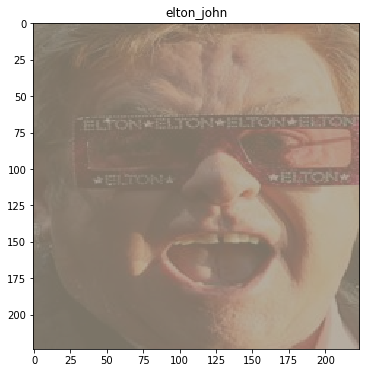

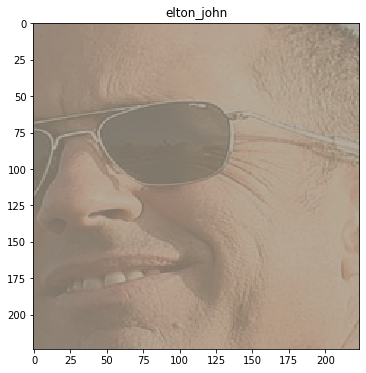

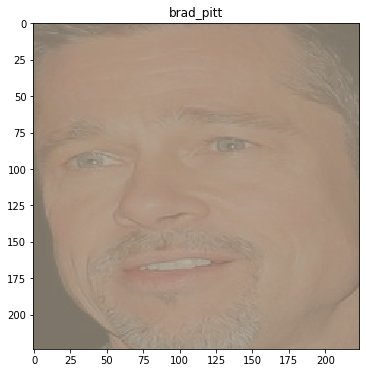

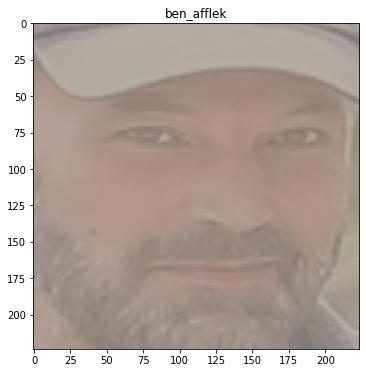

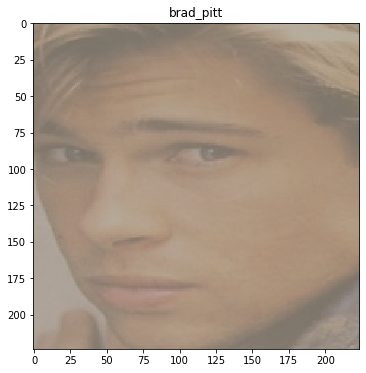

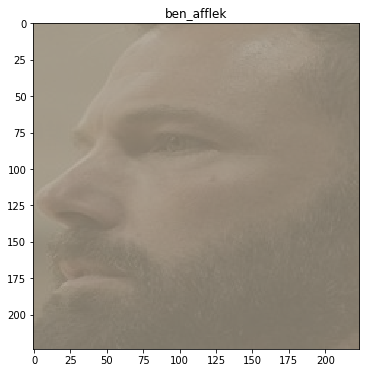

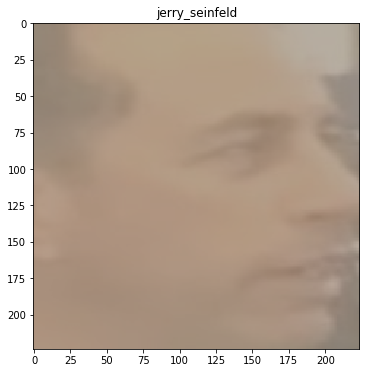

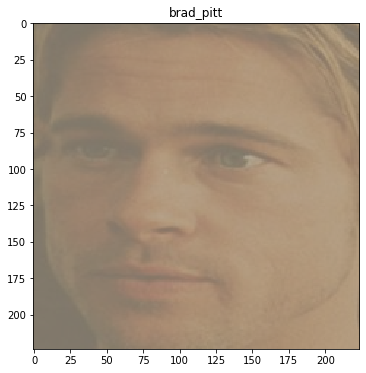

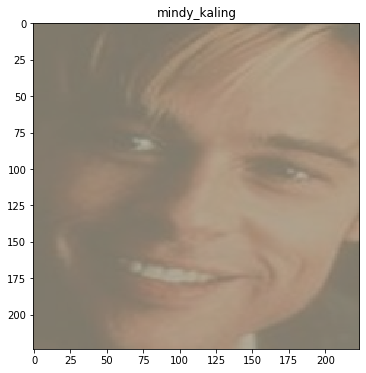

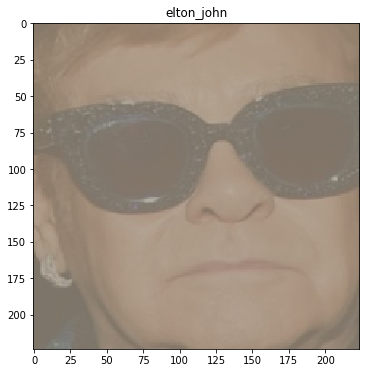

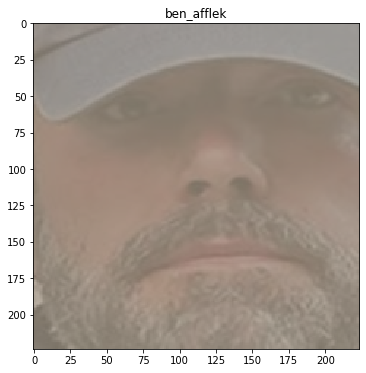

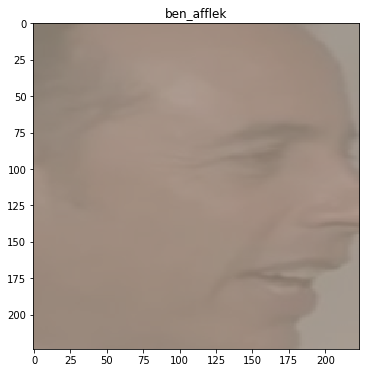

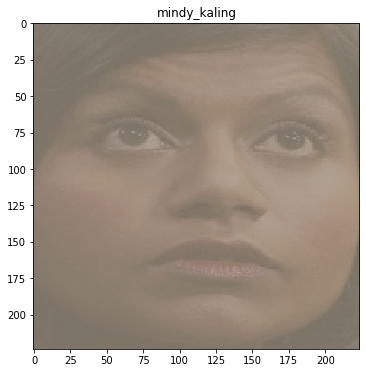

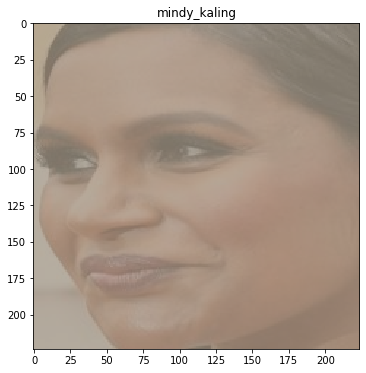

In [61]:
import glob
from PIL import Image
from torch.autograd import Variable
from os import listdir

with torch.no_grad():
    
    base_path = "./face_test24/"
    correct = 0
    total = 0
    array = ['ben_afflek', 'brad_pitt' ,'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
                             std=std)
    ])
    onlyfiles = [f for f in listdir(base_path)]
    print(onlyfiles)
    for files in onlyfiles:
        images=glob.glob(base_path + files)
        for image in images:
            img = Image.open(image)
            trans = transforms.ToPILImage()
            trans1 = transforms.ToTensor()
            transformed_image = test_transform(img).float()
            transformed_image = Variable(transformed_image, requires_grad=True)
            transformed_image = transformed_image.unsqueeze(0)
            transformed_image = transformed_image.to(device)
            outputs = model(transformed_image)
            _, predicted = torch.max(outputs.data, 1)
            predicted_index_value = predicted.cpu().numpy()[0]
            #print("Predicted image is : " +array[predicted_index_value])
            imshow(trans1(img),array[predicted_index_value])


###  load the model and use it again to evaluate ###

In [12]:
import torch
import torchvision
from torchvision import datasets,transforms 

import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
array = ['ben_afflek', 'brad_pitt' ,'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))

    plt.imshow(inp)
    plt.title(title)
    plt.pause(2)

model = torch.load('./model_final_laaz').eval()
criterion   = nn.CrossEntropyLoss()
optimizer   = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
from PIL import Image
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from PIL import Image
def extract_face(filename, required_size=(224, 224)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

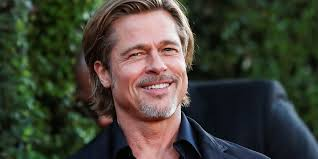

In [68]:
image = "b.jpg"
#image = Image.open(image)

In [15]:
 array = ['ben_afflek', 'brad_pitt' ,'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']
def predictPerson(url_image_to_predicte):
    result = extract_face(url_image_to_predicte)
    img = Image.fromarray(result)
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    transformed_image = test_transform(img).float()
    transformed_image = Variable(transformed_image, requires_grad=True)
    transformed_image = transformed_image.unsqueeze(0)
    transformed_image = transformed_image.to(device)
    outputs = model(transformed_image)
    _, predicted = torch.max(outputs.data, 1)
    predicted_index_value = predicted.cpu().numpy()[0]
    print("Predicted image is : " +array[predicted_index_value])
    imshow(trans1(img),array[predicted_index_value])

Predicted image is : brad_pitt


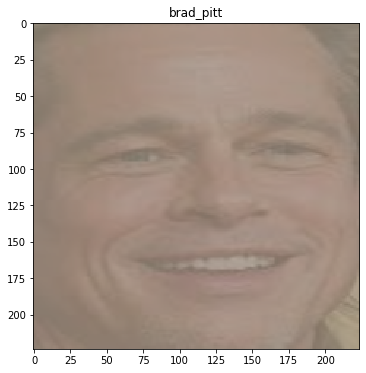

In [19]:
predictPerson("brad.jpg")

### FGSM attack on the model 

In [30]:
# generate FGSM attack 
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image , epsilon*sign_data_grad.detach()

In [33]:
def test_untargeted( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # Calculate the loss
        loss = criterion(output , target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        for i in range(len(final_pred)):
            if final_pred[i][0] == target[i]:
                correct += 1
            else :
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i][0], final_pred[i][0], data[i] , adv_ex[i]) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader) * 8)
    print("Epsilon: {}\tTest Accuracy = {}".format(epsilon, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [35]:
accuracies = []
examples = []
epsilons = [0.007, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_untargeted(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.007 Test Accuracy = 0.40625
Epsilon: 0.07 Test Accuracy = 0.28125
Epsilon: 0.1 Test Accuracy = 0.21875
Epsilon: 0.2 Test Accuracy = 0.1875
Epsilon: 0.3 Test Accuracy = 0.125
Epsilon: 0.4 Test Accuracy = 0.0625
Epsilon: 0.5 Test Accuracy = 0.03125


### adversarial exemple generated with epsilon = 0.1

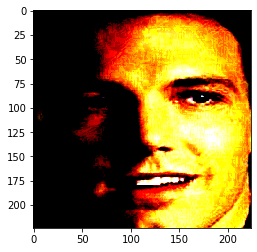

In [208]:
newimg = torch.from_numpy(advim[5]).squeeze().permute(1,2,0)
plt.imshow(newimg , cmap='gray')

### with epsilon = 0.6

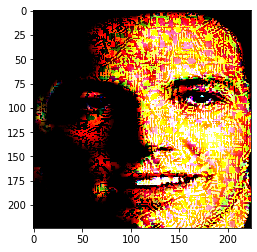

In [214]:
newimg = torch.from_numpy(advim[1]).squeeze().permute(1,2,0)
plt.imshow(newimg , cmap='gray')

In [17]:
def showAdversarialExp(advEx):
    list_faces = []
    for true_label , false_label , true_sample , adv_sample in advEx:
        list_faces.append( (0 , true_label , true_sample))
        list_faces.append( (1 , false_label , adv_sample))
    
    j = 1
    plt.figure(figsize=(15,15))
    for typeimage , classname , image in list_faces:
        plt.subplot(3 , 4 , j)
        if typeimage == 0:
            bening_sample = torch.from_numpy(image.detach().numpy()).squeeze().permute(1,2,0)
            plt.imshow(bening_sample)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.title("True Class : {}".format(array[classname]))
            j+=1
        else:
           adversarial_sample = torch.from_numpy(image).squeeze().permute(1,2,0) 
           plt.imshow(adversarial_sample)
           plt.xticks([], [])
           plt.yticks([], [])
           plt.title("Predicted class : {} ".format(array[classname]))
           j+=1
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


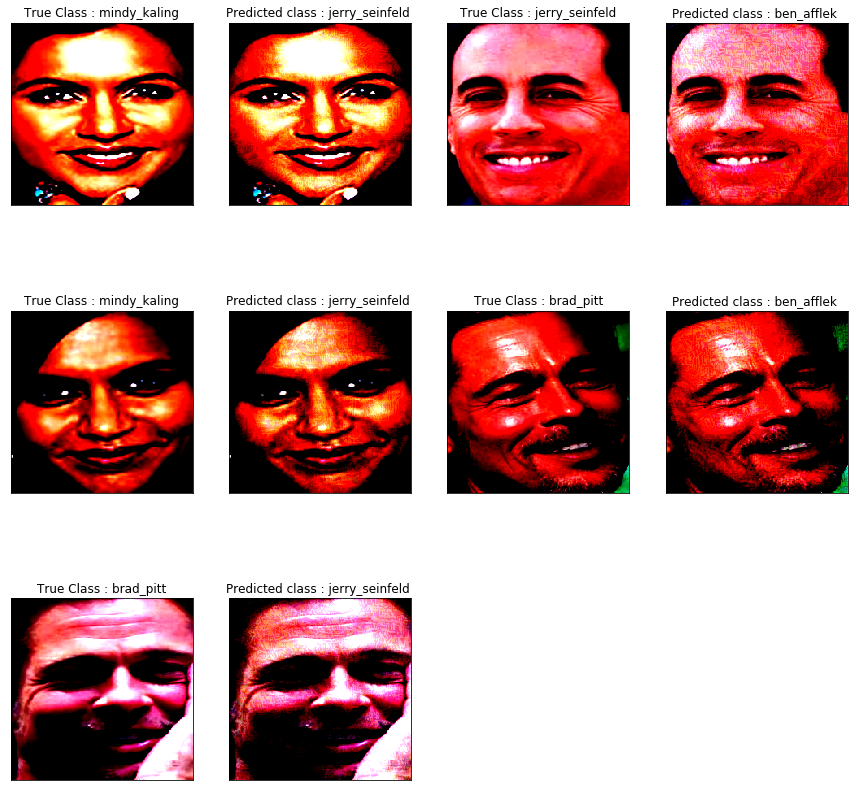

In [133]:
showAdversarialExp(advexemple_untargeted)

### Targgeted FGSM ###

In [27]:
# generate FGSM attack 
def Targetted_fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [28]:
def test( model, device, test_loader, epsilon , needed_class):
    # Accuracy counter
    correct = 0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:
    
        newTargget = torch.full((1,len(target)), needed_class)
        newTargget = torch.squeeze(newTargget, 0)
        # Send the data to the device
        data = data.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        # Calculate the loss
        loss = criterion(output , newTargget)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = Targetted_fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        for i in range(len(final_pred)):
            if final_pred[i][0] == target[i]:
                correct += 1
            else :
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i][0], final_pred[i][0], data[i] , adv_ex[i]) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader) * 8)
    print("Epsilon: {}\tTest Accuracy = {}".format(epsilon, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


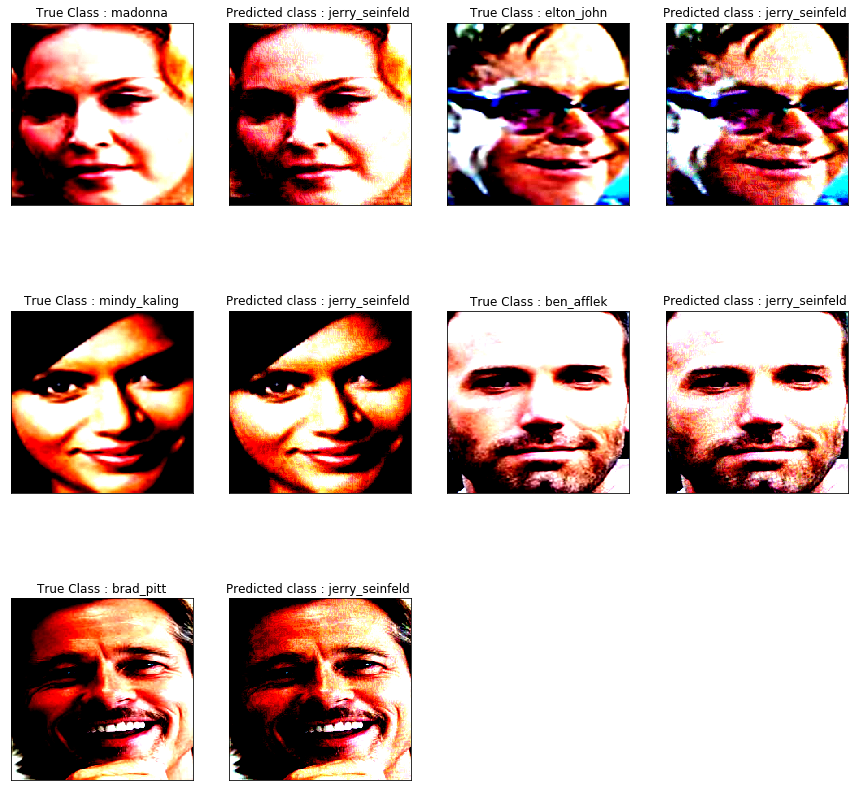

In [134]:
showAdversarialExp(advexemple_Targgeted)

### Adversarial attack using PGD ###

In [17]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=2) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

In [28]:
def testPGD( model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:
    
        #newTargget = torch.full((1,len(target)), needed_class)
        #newTargget = torch.squeeze(newTargget, 0)
        # Send the data to the device
        data = data.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        # Calculate the loss
        loss = criterion(output , target)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect datagrad
        data_grad = data.grad.data
        # Call PGD Attack
        perturbed_data = pgd_attack(model, data, target , eps=epsilon)
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1]
        for i in range(len(final_pred)):
            if final_pred[i][0] == target[i]:
                correct += 1
            else :
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i][0], final_pred[i][0], data[i] , adv_ex[i]) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader) * 8)
    print("Epsilon: {}\tTest Accuracy = {}".format(epsilon, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [29]:
accuracies = []
examples = []
epsilons = [0.007, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5]
# Run test for each epsilon
for eps in epsilons:
    acc = testPGD(model , device , test_loader , epsilon=eps)

Epsilon: 0.007	Test Accuracy = 0.34375
Epsilon: 0.07	Test Accuracy = 0.28125
Epsilon: 0.1	Test Accuracy = 0.28125
Epsilon: 0.2	Test Accuracy = 0.28125
Epsilon: 0.3	Test Accuracy = 0.25
Epsilon: 0.4	Test Accuracy = 0.25
Epsilon: 0.5	Test Accuracy = 0.25


In [152]:
!jt -r

Reset css and font defaults in:
C:\Users\PC\.jupyter\custom &
C:\Users\PC\AppData\Roaming\jupyter\nbextensions


In [1]:
!jt -t monokai -T -N